In [3]:
import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import setigen
import pandas as pd
import pickle
from scipy.stats import skew, kurtosis, norm
%matplotlib inline

In [2]:
import sklearn
print(sklearn.__version__)

0.22.1


In [4]:
lfiles = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

files = glob.glob(lfiles[1])
print(files)

['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5']


In [4]:
fb = bl.Waterfall(lfiles[0])
fb.info()


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :           1688.9648423530161 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nifs :                                1
     rawdatafile : guppi_58832_16209_MESSIER031_0057.0000.raw
     source_name :                       MESSIER031
         src_dej :                      41:16:03.72
         src_raj :                      0:42:44.448
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2019-12-15T04:30:09.000
    tstart (MJD) :                

In [5]:
fb.blank_dc(64)

extracting integration 0...


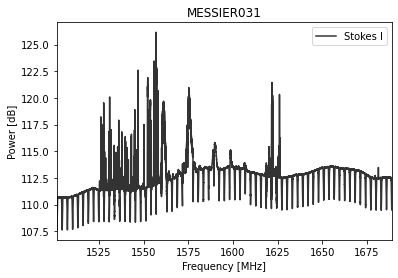

In [6]:
fb.plot_spectrum(logged=True)

In [7]:
# scratch work which is not to be deleted in case it is useful later

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ctr_freqs = df['Uncorrected_Frequency'].values
start_freqs = df['freq_start'].values
end_freqs = df['freq_end'].values

for ii, freq in enumerate(ctr_freqs):
    #fb.plot_waterfall(f_start=start_freqs[ii]-0.002, f_stop=end_freqs[ii]+0.002, logged=True)
    print(f'Center frequency should be {freq} MHz.')
    print(f'Starting frequency is {(start_freqs[ii]-freq)*1000000} Hz.')
    print(f'Ending frequency is {(end_freqs[ii]-freq)*1000000} Hz.')
    window_lengths = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010]
    window_lengths = np.linspace(0.0002, 0.0020, 37)
    kurtoses = []
    for wl in window_lengths:
        print(f'Pulling dynamic spectrum data (WL = {wl}) ...')
        freqs, dynamic_spectrum = fb.grab_data(f_start=freq-wl/2, f_stop=freq+wl/2) # grab data around hit
        power_spectrum = np.average(dynamic_spectrum, axis=0)
        power_spectrum = power_spectrum / power_spectrum.max()
        kurt = kurtosis(power_spectrum, fisher=False)
        print(f'Spectral kurtosis is {kurt}.')
        kurtoses.append(kurt)
    #print('Plotting ...')
    wl = 0.000200
    #freqs, dynamic_spectrum = fb.grab_data(f_start=start_freqs[ii]-wl/2, f_stop=end_freqs[ii]+wl/2)
    freqs, dynamic_spectrum = fb.grab_data(f_start=freq-wl/2, f_stop=freq+wl/2)
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = power_spectrum / power_spectrum.max()
    kurt = kurtosis(power_spectrum, fisher=False)
    fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [5, 1, 4]})
    axs[0].plot((freqs-freq)*1000000, power_spectrum)
    axs[1].hist(power_spectrum, bins=20, log=True, orientation='horizontal')
    axs[0].set_xlabel(f'frequency [Hz] displaced from {freq} MHz')
    axs[1].set_yticklabels([])
    axs[0].text(0.1, 0.9, f'BW = {round(wl*1000000)} Hz', horizontalalignment='left', verticalalignment='center', transform=axs[0].transAxes,
                bbox=dict(facecolor='none', edgecolor='black'))
    axs[2].scatter(np.array(window_lengths)*1000000, kurtoses)
    axs[2].set_xlabel('bandwidth of window [Hz]')
    axs[2].set_ylabel('spectral kurtosis')
    fig.tight_layout()
    #plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    #plt.scatter(np.array(window_lengths)*100000, kurtoses)
    #plt.xlabel('bandwidth of window [Hz]')
    #plt.title(r'narrowband hit ($\Delta f \sim 9$ Hz)')
    #plt.ylabel('spectral kurtosis')
    #plt.show()
    break

print('Done!')

Center frequency should be 1681.553703 MHz.
Starting frequency is 2191.000000038912 Hz.
Ending frequency is -2187.000000049011 Hz.
Pulling dynamic spectrum data (WL = 0.0002) ...
Spectral kurtosis is 25.491974858242518.
Pulling dynamic spectrum data (WL = 0.00025) ...
Spectral kurtosis is 31.739001322267246.
Pulling dynamic spectrum data (WL = 0.00030000000000000003) ...
Spectral kurtosis is 37.908597323518315.
Pulling dynamic spectrum data (WL = 0.00035) ...


Exception: Waterfall.grab_data: Too much data requested

In [86]:
# pull spectral kurtosis, skewness, something to do with multimodality (Sarle's coefficient? Ashman's D?)

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ctr_freqs = df['Uncorrected_Frequency'].values
start_freqs = df['freq_start'].values
end_freqs = df['freq_end'].values

drifts = df['Drift_Rate'].values
snrs = df['SNR'].values

kurts = []
skews = []
sarles = []

for ii, freq in enumerate(ctr_freqs):

    wl = 0.002700    # 2.7 kHz, from Caleb Painter's work

    freqs, dynamic_spectrum = fb.grab_data(f_start=freq-wl/2, f_stop=freq+wl/2) # grab data around hit
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide
    ku = kurtosis(power_spectrum, fisher=False)  # I don't think it should matter whether this is Fisher or Pearson,
                                                # but Caleb used Fisher, so we do too in case we ever have to compare results
    sk = skew(power_spectrum)
    sarle = (sk**2 + 1) / ku           # Sarle's bimodality coefficient
                                       # = 5/9 for uniform, larger possibly suggests multimodality

    print(f'Hit number {ii} of {len(ctr_freqs)}:')
    print(f'    Spectral kurtosis is {ku}.')
    print(f'    Spectral skewness is {sk}.')
    print(f'    Sarle\'s coefficient is {sarle}.')

    kurts.append(ku)
    skews.append(sk)
    sarles.append(sarle)

kurts = np.array(kurts)
skews = np.array(skews)
sarles = np.array(sarles)

print('Done!')

Hit number 0 of 3068:
    Spectral kurtosis is 129.90569977367517.
    Spectral skewness is 8.573884010314941.
    Sarle's coefficient is 0.5735813528748156.
Hit number 1 of 3068:
    Spectral kurtosis is 87.37465812398254.
    Spectral skewness is 6.674641132354736.
    Sarle's coefficient is 0.521327753650105.
Hit number 2 of 3068:
    Spectral kurtosis is 71.97481641578152.
    Spectral skewness is 6.56630802154541.
    Sarle's coefficient is 0.6129421821510675.
Hit number 3 of 3068:
    Spectral kurtosis is 202.8515619088712.
    Spectral skewness is 12.691490173339844.
    Sarle's coefficient is 0.7989779388180985.
Hit number 4 of 3068:
    Spectral kurtosis is 86.5982731985516.
    Spectral skewness is 6.025259971618652.
    Sarle's coefficient is 0.4307679165848994.
Hit number 5 of 3068:
    Spectral kurtosis is 198.67820316094384.
    Spectral skewness is 11.019474029541016.
    Sarle's coefficient is 0.6162166052435689.
Hit number 6 of 3068:
    Spectral kurtosis is 61.2003040

In [3]:
np.savez('/datax/scratch/benjb/kurtoses.npz', kurts)
np.savez('/datax/scratch/benjb/skewnesses.npz', skews)
np.savez('/datax/scratch/benjb/sarles.npz', sarles)

NameError: name 'kurts' is not defined

[1.78368037 0.31942856]
(0.9929878090792901, 0.0)


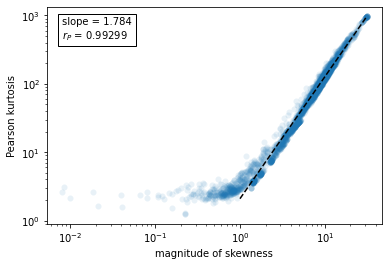

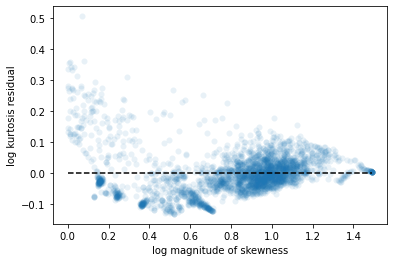

In [34]:
from scipy import stats

cut = 1

plt.scatter(np.abs(skews), kurts, alpha=0.1, linewidths=0)
plt.xlabel('magnitude of skewness')
plt.ylabel('Pearson kurtosis')
plt.xscale('log')
plt.yscale('log')
coef = np.polyfit(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]), 1)
poly1d_fn = np.poly1d(coef)
print(poly1d_fn.c)
x = np.sort(np.abs(skews)[np.where(np.abs(skews) > cut)[0]])
xmod = np.log10(x)
ymod = poly1d_fn(xmod)
y = 10**ymod

xunsorted = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
xmodunsorted = np.log10(xunsorted)
ymodunsorted = poly1d_fn(xmodunsorted)
yunsorted = 10**ymodunsorted

plt.plot(x, y, '--k')
#plt.scatter(xunsorted, kurts[np.where(np.abs(skews) > 1)[0]], color='r')

resids = kurts[np.where(np.abs(skews) > cut)[0]] - yunsorted
expected = np.zeros_like(yunsorted)

pearsonr = stats.pearsonr(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]))
print(pearsonr)

stat_string = (f'slope = {round(poly1d_fn.c[0],3)}\n'
    r'$r_P$' + f' = {round(pearsonr[0],5)}')

plt.text(np.abs(skews).min(), kurts.max(), stat_string, horizontalalignment='left', verticalalignment='top', 
         bbox=dict(facecolor='none', edgecolor='black'))

plt.show()

plt.scatter(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]) - ymodunsorted, alpha=0.1, linewidths=0)
plt.plot(np.linspace(0, np.log10(np.max(skews)), 100), np.zeros(100), '--k')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('log magnitude of skewness')
plt.ylabel('log kurtosis residual')
plt.savefig('/datax/scratch/benjb/skewness_kurtosis_correlation_residuals.pdf')
plt.show()

In [2]:
skews = np.load('/datax/scratch/benjb/skewnesses.npz')['arr_0']
kurts = np.load('/datax/scratch/benjb/kurtoses.npz')['arr_0']
sarles = np.load('/datax/scratch/benjb/sarles.npz')['arr_0']
corrs = np.load('/datax/scratch/benjb/corrs.npz')['arr_0']
tbws = np.load('/datax/scratch/benjb/tbws.npz')['arr_0']

In [7]:
print(tbws[:10])

[0.00469117 0.0284631  0.01620296 0.0082408  0.05       0.0446717
 0.05       0.03991121 0.03185809 0.0254299 ]


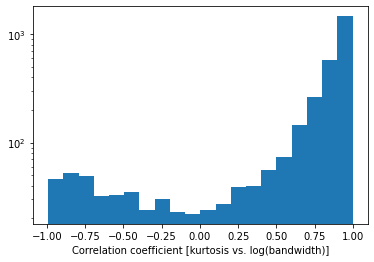

In [6]:
plt.hist(corrs, bins=20)
plt.xlabel('Correlation coefficient [kurtosis vs. log(bandwidth)]')
plt.yscale('log')
plt.show()

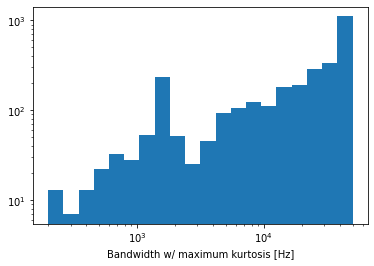

In [13]:
hist, bins = np.histogram(tbws*1e6, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.hist(tbws*1e6, bins=logbins)
plt.xlabel('Bandwidth w/ maximum kurtosis [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.show()

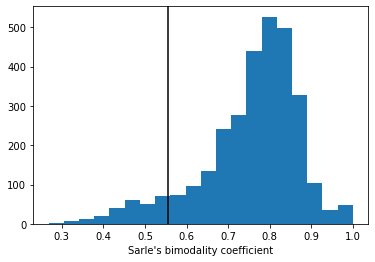

In [11]:
plt.hist(sarles, bins=20)
plt.axvline(5/9, c='k')
plt.xlabel('Sarle\'s bimodality coefficient')
plt.show()

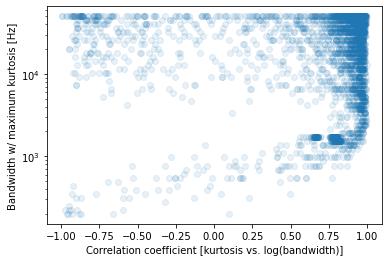

In [15]:
p1 = corrs
p2 = tbws*1e6

plt.scatter(p1, p2, alpha=0.1)
plt.yscale('log')
plt.xlabel('Correlation coefficient [kurtosis vs. log(bandwidth)]')
plt.ylabel('Bandwidth w/ maximum kurtosis [Hz]')
plt.show()

In [ ]:
### (H)DBSCAN CLUSTERING



In [75]:
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

plt.clf()

fig, axs = plt.subplots(2, 2, figsize = (8,6), gridspec_kw={'width_ratios': [5, 1]})
#fig.tight_layout()
plt.subplots_adjust(wspace=0)

#for ii, wl in enumerate(window_lengths):
def animate(ii):
    axs[0,0].clear()
    axs[0,1].clear()
    axs[1,0].clear()
    wl = window_lengths[ii]
    #freqs, dynamic_spectrum = fb.grab_data(f_start=start_freqs[ii]-wl/2, f_stop=end_freqs[ii]+wl/2)
    freqs, dynamic_spectrum = fb.grab_data(f_start=freq-wl/2, f_stop=freq+wl/2)
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = power_spectrum / power_spectrum.max()
    kurt = kurtosis(power_spectrum, fisher=False)
    axs[0,0].plot((freqs-freq)*1000000, power_spectrum)
    axs[0,0].set_ylabel('normalized intensity')
    axs[0,1].hist(power_spectrum, bins=20, log=True, orientation='horizontal')
    axs[0,0].set_xlabel(f'frequency [Hz] displaced from {freq} MHz')
    axs[0,1].set_yticklabels([])
    axs[0,0].text(0.05, 0.9, f'BW = {round(wl*1000000)} Hz', horizontalalignment='left', verticalalignment='center', transform=axs[0,0].transAxes,
                bbox=dict(facecolor='none', edgecolor='black'))
    axs[1,0].scatter(np.array(window_lengths)*1000000, kurtoses)
    axs[1,0].scatter(wl*1000000, kurtoses[ii], color='red')
    axs[1,0].set_xlabel('bandwidth of window [Hz]')
    axs[1,0].set_ylabel('spectral kurtosis')
    axs[1,1].set_visible(False)

ani = FuncAnimation(fig, animate, frames=len(window_lengths),
                    interval=500, repeat=True)

plt.close()

from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("/datax/scratch/benjb/kurtosis_animation.gif", dpi=300,
         writer=PillowWriter(fps=1))

matplotlib.animation INFO     Animation.save using <class 'matplotlib.animation.PillowWriter'>


<Figure size 432x288 with 0 Axes>

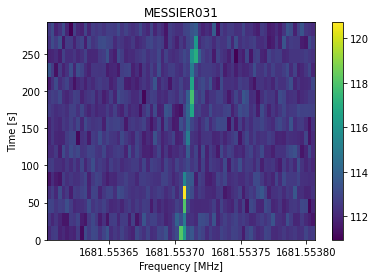

In [34]:
fb.plot_waterfall(f_start=ctr_freqs[0]-0.0001, f_stop=ctr_freqs[0]+0.0001, logged=True)

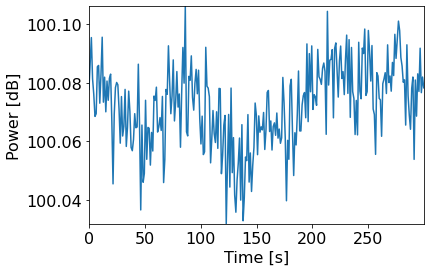

In [22]:
fb.plot_time_series(f_start=1699.95, f_stop=1700.05)

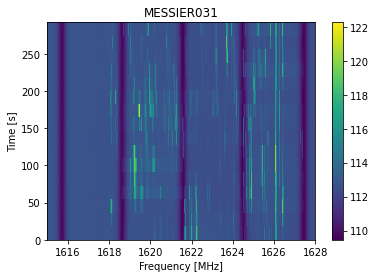

In [47]:
fb.plot_waterfall(f_start=1615, f_stop=1628, logged=True)

In [7]:
from turbo_seti.find_event.plot_event import make_waterfall_plots

TypeError: can only concatenate str (not "int") to str

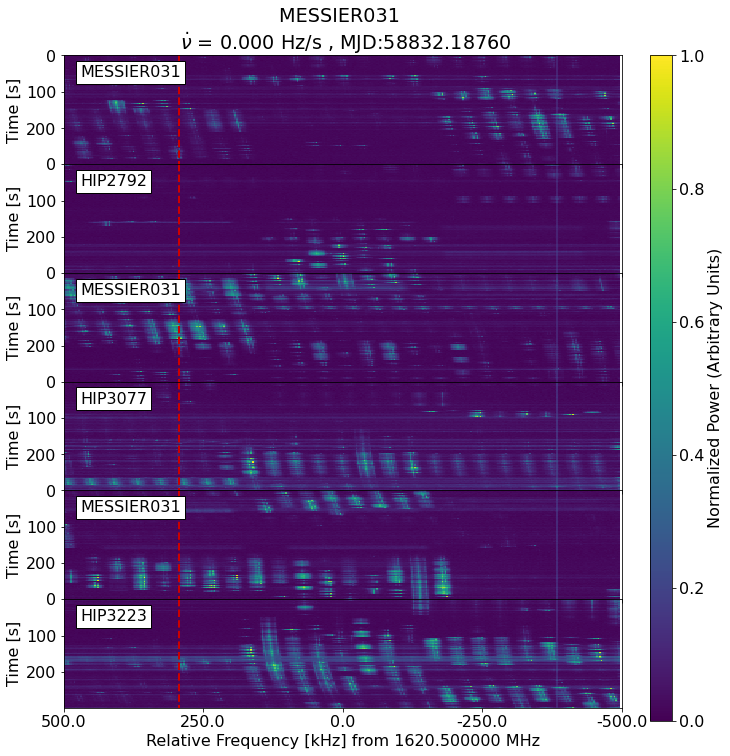

In [15]:
make_waterfall_plots(lfiles, 'MESSIER031', 1620, 1621, 0.0, 1620.793819, 3, 
                     ['MESSIER031','HIP2792','MESSIER031','HIP3077','MESSIER031','HIP3223'], 0)

In [43]:
dats = glob.glob(f'/datax/scratch/benjb/m31_l_data/*.dat')
df = pd.read_table(dats[0], sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
df

,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,1,-0.0,1.865467e+06,2062.499999,2062.499999,524288,2062.501633,2062.498370,0.0,0.0,0,40856
1,2,-0.0,9.071087e+05,2059.570311,2059.570311,524288,2059.571946,2059.568682,0.0,0.0,1,13168
2,3,-0.0,9.094708e+05,2056.640624,2056.640624,524288,2056.642258,2056.638995,0.0,0.0,2,13168
3,4,-0.0,9.140136e+05,2053.710936,2053.710936,524288,2053.712571,2053.709307,0.0,0.0,3,13168
4,5,-0.0,9.178268e+05,2050.781249,2050.781249,524288,2050.782883,2050.779620,0.0,0.0,4,16372
...,...,...,...,...,...,...,...,...,...,...,...,...
82,83,-0.0,8.467148e+05,1889.648436,1889.648436,524288,1889.650071,1889.646807,0.0,0.0,59,13174
83,84,-0.0,7.303255e+05,1886.718749,1886.718749,524288,1886.720383,1886.717120,0.0,0.0,60,13168
84,85,-0.0,5.368764e+05,1883.789061,1883.789061,524288,1883.790696,1883.787432,0.0,0.0,61,13168
85,86,-0.0,3.139061e+05,1880.859374,1880.859374,524288,1880.861008,1880.857745,0.0,0.0,62,13168


In [19]:
df = pd.read_csv('/datax/scratch/benjb/blc73_found_event_table_3.csv')
df

,Unnamed: 0,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,344,345,-0.612255,17.395712,1598.484902,926752,1598.487093,1598.482715,30,670045,...,41d16m03.72s,18.253611,-2.793968,4.0,292.057776,MESSIER031_344,on_table_1,2.0,0,0.0
1,3426,359,-0.540826,11.326997,1598.484536,926883,1598.486727,1598.482348,30,2054851,...,41d14m00.6s,18.253611,-2.793968,4.0,292.057776,MESSIER031_344,on_table_2,NaN,0,642.0
2,6403,538,-0.469396,11.004164,1598.484215,926998,1598.486405,1598.482027,30,2038270,...,41d15m39.24s,18.253611,-2.793968,4.0,292.057776,MESSIER031_344,on_table_3,NaN,0,1276.0
3,724,725,-0.316332,10.797793,1574.331319,134472,1574.333510,1574.329132,39,16012,...,41d16m03.72s,18.253611,-2.793968,4.0,292.057776,MESSIER031_724,on_table_1,2.0,0,0.0
4,3717,650,-0.306128,10.316234,1574.331079,134558,1574.333270,1574.328891,39,6557,...,41d14m00.6s,18.253611,-2.793968,4.0,292.057776,MESSIER031_724,on_table_2,NaN,0,642.0
5,6828,963,-0.204085,13.387509,1574.330738,134680,1574.332929,1574.328551,39,79903,...,41d15m39.24s,18.253611,-2.793968,4.0,292.057776,MESSIER031_724,on_table_3,NaN,0,1276.0


In [19]:
def make_turboSETI_distribution_plots(directory):

    #ts_idxs = []
    ts_freqs = []
    ts_drifts = []
    ts_snrs = []

    ts1_freqs = []
    ts1_drifts = []
    ts1_snrs = []

    ts2_freqs = []
    ts2_drifts = []
    ts2_snrs = []

    ts3_freqs = []
    ts3_drifts = []
    ts3_snrs = []

    num_hits = 0

    node_files = glob.glob(f'{directory}/*_found_event_table_1.csv')

    for file in node_files:

        ts1_start_idx = len(ts1_freqs)
        ts2_start_idx = len(ts2_freqs)
        ts3_start_idx = len(ts3_freqs)
        
        start = directory
        end = '_found_event_table'
        node_prefix = (file.split(start))[1].split(end)[0]

        print(f'Working on node {node_prefix} ...')

        dats = glob.glob(f'{directory}bDC_{node_prefix}*.dat')

        for i in range(len(dats)):
            df = pd.read_table(dats[i], sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
        
            fs = df['freq_start'].values
            ds = df['Drift_Rate'].values
            ss = df['SNR'].values

            ts_freqs = np.concatenate((ts_freqs, fs))
            ts_drifts = np.concatenate((ts_drifts, ds))
            ts_snrs = np.concatenate((ts_snrs, ss))

        # grab parameters for events from each of the three filter levels

        num_csvs = len(glob.glob(f'{directory}{node_prefix}_found_event_table_*.csv'))

        num_hits += len(ts_freqs)

        if num_csvs >= 1:
            df = pd.read_csv(f'{directory}{node_prefix}_found_event_table_1.csv')
            fs1 = df['FreqStart'].values
            ds1 = df['DriftRate'].values
            ss1 = df['SNR'].values
            ts1_freqs = np.concatenate((ts1_freqs, fs1))
            ts1_drifts = np.concatenate((ts1_drifts, ds1))
            ts1_snrs = np.concatenate((ts1_snrs, ss1))

            # filter out duplicates
            ts1_idxs = df['Unnamed: 0'].values
            #idxs_for_deletion = []
            #for idx in ts1_idxs:
            #    idxs_for_deletion.append(np.where(ts_idxs == idx)[0])
            #ts_freqs = np.delete(ts_freqs, idxs_for_deletion)
            #ts_drifts = np.delete(ts_drifts, idxs_for_deletion)
            #ts_snrs = np.delete(ts_snrs, idxs_for_deletion)

            if num_csvs >= 2:
                df = pd.read_csv(f'{directory}{node_prefix}_found_event_table_2.csv')
                fs2 = df['FreqStart'].values
                ds2 = df['DriftRate'].values
                ss2 = df['SNR'].values
                ts2_freqs = np.concatenate((ts2_freqs, fs2))
                ts2_drifts = np.concatenate((ts2_drifts, ds2))
                ts2_snrs = np.concatenate((ts2_snrs, ss2))

                # filter out duplicates
                ts2_idxs = df['Unnamed: 0'].values
                idxs_for_deletion = []
                for idx in ts2_idxs:
                    idxs_for_deletion.append(np.where(ts1_idxs == idx)[0])
                idxs_for_deletion = [idx + ts1_start_idx for idx in idxs_for_deletion]
                ts1_freqs = np.delete(ts1_freqs, idxs_for_deletion)
                ts1_drifts = np.delete(ts1_drifts, idxs_for_deletion)
                ts1_snrs = np.delete(ts1_snrs, idxs_for_deletion)

                if num_csvs == 3:
                    df = pd.read_csv(f'{directory}{node_prefix}_found_event_table_3.csv')
                    fs3 = df['FreqStart'].values
                    ds3 = df['DriftRate'].values
                    ss3 = df['SNR'].values
                    ts3_freqs = np.concatenate((ts3_freqs, fs3))
                    ts3_drifts = np.concatenate((ts3_drifts, ds3))
                    ts3_snrs = np.concatenate((ts3_snrs, ss3))

                    # filter out duplicates
                    ts3_idxs = df['Unnamed: 0'].values
                    idxs_for_deletion = []
                    for idx in ts3_idxs:
                        idxs_for_deletion.append(np.where(ts2_idxs == idx)[0])
                    idxs_for_deletion = [idx + ts2_start_idx for idx in idxs_for_deletion]
                    ts2_freqs = np.delete(ts2_freqs, idxs_for_deletion)
                    ts2_drifts = np.delete(ts2_drifts, idxs_for_deletion)
                    ts2_snrs = np.delete(ts2_snrs, idxs_for_deletion)

                #else:
                #    ts3_freqs = ts3_drifts = ts3_snrs = None
            #else:
            #    ts2_freqs = ts2_drifts = ts2_snrs = None
            #    ts3_freqs = ts3_drifts = ts3_snrs = None
        #else:
        #    ts1_freqs = ts1_drifts = ts1_snrs = None
        #    ts2_freqs = ts2_drifts = ts2_snrs = None
        #    ts3_freqs = ts3_drifts = ts3_snrs = None
    
    print(ts_freqs)
    #print(ts1_freqs)
    ts_freqs = ts_freqs[np.where((ts_freqs < 1200) | (ts_freqs > 1340))[0]]
    ts_drifts = ts_drifts[np.where((ts_freqs < 1200) | (ts_freqs > 1340))[0]]
    ts_snrs = ts_snrs[np.where((ts_freqs < 1200) | (ts_freqs > 1340))[0]]

    ts1_freqs = ts1_freqs[np.where((ts1_freqs < 1200) | (ts1_freqs > 1340))[0]]
    ts1_drifts = ts1_drifts[np.where((ts1_freqs < 1200) | (ts1_freqs > 1340))[0]]
    ts1_snrs = ts1_snrs[np.where((ts1_freqs < 1200) | (ts1_freqs > 1340))[0]]

    ts2_freqs = ts2_freqs[np.where((ts2_freqs < 1200) | (ts2_freqs > 1340))[0]]
    ts2_drifts = ts2_drifts[np.where((ts2_freqs < 1200) | (ts2_freqs > 1340))[0]]
    ts2_snrs = ts2_snrs[np.where((ts2_freqs < 1200) | (ts2_freqs > 1340))[0]]

    ts3_freqs = ts3_freqs[np.where((ts3_freqs < 1200) | (ts3_freqs > 1340))[0]]
    ts3_drifts = ts3_drifts[np.where((ts3_freqs < 1200) | (ts3_freqs > 1340))[0]]
    ts3_snrs = ts3_snrs[np.where((ts3_freqs < 1200) | (ts3_freqs > 1340))[0]]

    # frequency distribution:

    plt.clf()
    plt.hist(ts_freqs, bins=20, color='steelblue')
    plt.axvspan(1200, 1340, color='gray', alpha=0.2) # notch filter
    plt.title(f'turboSETI hit start frequencies (n={num_hits})')
    plt.xlabel('starting frequency [MHz]')
    plt.savefig('/datax/scratch/benjb/tseti_hit_freqs_dist.pdf')

    # frequency distribution where 1 bin = 1 coarse channel:

    plt.clf()
    plt.hist(ts_freqs, bins=64, color='steelblue')
    plt.axvspan(1200, 1340, color='gray', alpha=0.2) # notch filter
    plt.title(f'turboSETI hit start frequencies (n={num_hits})')
    plt.xlabel('starting frequency [MHz]')
    plt.savefig('/datax/scratch/benjb/tseti_hit_freqs_dist_64bins.pdf')

    # drift rate distribution

    plt.clf()
    plt.hist(ts_drifts, bins=20, color='rosybrown')
    plt.title(f'turboSETI hit drift rates (n={num_hits})')
    plt.xlabel('drift rate [Hz/s]')
    plt.yscale('log')
    plt.savefig('/datax/scratch/benjb/tseti_hit_drifts_dist.pdf')

    # SNR distribution

    plt.clf()

    hist, bins = np.histogram(ts_snrs, bins=20)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

    plt.hist(ts_snrs, bins=logbins, color='mediumseagreen')
    plt.title(f'turboSETI hit SNRs (n={num_hits})')
    plt.xlabel('SNR')
    plt.xscale('log')
    plt.savefig('/datax/scratch/benjb/tseti_hit_snrs_dist.pdf')

    # freq / drift 2D distribution

    plt.clf()
    plt.scatter(ts_freqs, ts_drifts, c='k', alpha=0.1, linewidths=0, label='hit')
    plt.axvspan(1200, 1340, color='gray', alpha=0.2) # notch filter
    plt.scatter(ts1_freqs, ts1_drifts, c='firebrick', alpha=0.5, marker='x', label=f'filter 1 (n={len(ts1_freqs)})')
    plt.scatter(ts2_freqs, ts2_drifts, c='goldenrod', alpha=0.5, marker='+', label=f'filter 2 (n={len(ts2_freqs)})')
    plt.scatter(ts3_freqs, ts3_drifts, c='forestgreen', alpha=1, marker='*', label=f'filter 3 (n={len(ts3_freqs)})')
    plt.xlabel('starting frequency [MHz]')
    plt.ylabel('drift rate [Hz/s]')
    plt.title(f'turboSETI hits (n={num_hits})')
    plt.legend()
    plt.savefig('/datax/scratch/benjb/tseti_hit_freq_drift_dist.pdf')

    # drift / SNR 2D distribution

    plt.clf()
    plt.scatter(ts_drifts, ts_snrs, c='k', alpha=0.1, linewidths=0, label='hit')
    plt.scatter(ts1_drifts, ts1_snrs, c='firebrick', alpha=0.5, marker='x', label=f'filter 1 (n={len(ts1_drifts)})')
    plt.scatter(ts2_drifts, ts2_snrs, c='goldenrod', alpha=0.5, marker='+', label=f'filter 2 (n={len(ts2_drifts)})')
    plt.scatter(ts3_drifts, ts3_snrs, c='forestgreen', alpha=1, marker='*', label=f'filter 3 (n={len(ts3_drifts)})')
    plt.ylabel('SNR')
    plt.xlabel('drift rate [Hz/s]')
    plt.yscale('log')
    plt.title(f'turboSETI hits (n={num_hits})')
    plt.legend()
    plt.savefig('/datax/scratch/benjb/tseti_hit_drift_snr_dist.pdf')

    # freq / SNR 2D distribution

    plt.clf()
    plt.scatter(ts_freqs, ts_snrs, c='k', alpha=0.1, linewidths=0, label='hit')
    plt.axvspan(1200, 1340, color='gray', alpha=0.2) # notch filter
    plt.scatter(ts1_freqs, ts1_snrs, c='firebrick', alpha=0.5, marker='x', label=f'filter 1 (n={len(ts1_freqs)})')
    plt.scatter(ts2_freqs, ts2_snrs, c='goldenrod', alpha=0.5, marker='+', label=f'filter 2 (n={len(ts2_freqs)})')
    plt.scatter(ts3_freqs, ts3_snrs, c='forestgreen', alpha=1, marker='*', label=f'filter 3 (n={len(ts3_freqs)})')
    plt.ylabel('SNR')
    plt.xlabel('starting frequency [MHz]')
    plt.yscale('log')
    plt.title(f'turboSETI hits (n={num_hits})')
    plt.legend()
    plt.savefig('/datax/scratch/benjb/tseti_hit_freq_snr_dist.pdf')


        

In [56]:
import os
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline

# Create a simple .lst file of the .dat files in the data directory
dat_list = sorted(glob.glob(os.path.join('/datax/scratch/benjb/m31_l_data/', '*.dat')))
    
# This writes the .dat files into a .lst, as required by the find_event_pipeline:
dat_list_path = os.path.join('/datax/scratch/benjb/m31_l_data/', 'dat_files.lst')
with open(dat_list_path, 'w') as f:
    for dat_path in dat_list:
        f.write(dat_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(dat_list_path, 'r') as f:
    print(f.read())

csvf_path = os.path.join('/home/benjb/bliss-notebooks/', 'found_event_table_1.csv')
find_event_pipeline(dat_list_path, 
                    filter_threshold = 1, 
                    number_in_cadence = len(dat_list), 
                    csv_name=csvf_path, 
                    saving=True)

csvf_path = os.path.join('/home/benjb/bliss-notebooks/', 'found_event_table_2.csv')
find_event_pipeline(dat_list_path, 
                    filter_threshold = 2, 
                    number_in_cadence = len(dat_list), 
                    csv_name=csvf_path, 
                    saving=True)

csvf_path = os.path.join('/home/benjb/bliss-notebooks/', 'found_event_table_3.csv')
find_event_pipeline(dat_list_path, 
                    filter_threshold = 3, 
                    number_in_cadence = len(dat_list), 
                    csv_name=csvf_path, 
                    saving=True)

/datax/scratch/benjb/m31_l_data/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/datax/scratch/benjb/m31_l_data/blc72_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat
/datax/scratch/benjb/m31_l_data/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/datax/scratch/benjb/m31_l_data/blc72_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat
/datax/scratch/benjb/m31_l_data/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/datax/scratch/benjb/m31_l_data/blc72_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat


************   BEGINNING FIND_EVENT PIPELINE   **************

Assuming the first observation is an ON
find_event_pipeline: file = blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat, tstart = 58832.18760416667, source_name = MESSIER031
find_event_pipeline: file = blc72_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat, tstart = 58832.19131944444, source_name = HIP2792
find_event_pipeline: file = blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat, tstart = 588

[]

Working on node blc73 ...
Working on node blc72 ...
Working on node blc74 ...
Working on node blc75 ...
[1627.439976 1624.510288 1621.580601 1618.650913 1601.072788 1589.354038
 1577.635288 1574.705601 1562.986851 1560.057163 1557.127476 1554.197788
 1551.268101 1548.338413 1545.408726 1542.479038 1539.549351 1536.619663
 1533.689976 1530.760288 1527.830601 1627.439976 1624.510288 1621.580601
 1618.650913 1589.354038 1577.635288 1574.705601 1562.986851 1560.057163
 1557.127476 1554.197788 1551.268101 1548.338413 1545.408726 1542.479038
 1539.549351 1536.619663 1533.689976 1530.760288 1527.830601 1627.439976
 1624.510288 1621.580601 1618.650913 1601.072788 1589.354038 1574.705601
 1562.986851 1560.057163 1557.127476 1554.197788 1551.268101 1548.338413
 1545.408726 1542.479038 1539.549351 1536.619663 1533.689976 1530.760288
 1527.830601 1627.439976 1624.510288 1621.580601 1618.650913 1601.072788
 1589.354038 1574.705601 1562.986851 1560.057163 1557.127476 1554.197788
 1551.268101 1548.33

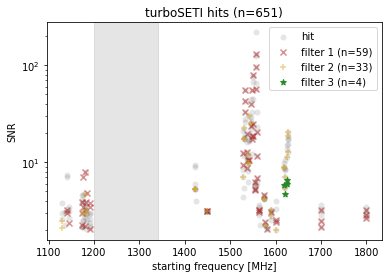

In [20]:
make_turboSETI_distribution_plots('/datax/scratch/benjb/')

In [ ]:
def make_bliss_distribution_plots(hits_file):
    
    with open(hits_file, 'rb') as fp:
        bliss_hits = pickle.load(fp)
    
    freqs = []
    drifts = []
    snrs = []

    for hit in bliss_hits:
        freq = (hit.split('start_freq_MHz='))[1].split(' (.index')[0]
        drift = (hit.split('drift_rate_Hz_per_second='))[1].split(' (.index')[0]
        snr = (hit.split('SNR='))[1].split(', ')[0]
        freqs.append(float(freq))
        drifts.append(float(drift))
        snrs.append(float(snr))

    freqs = np.array(freqs)
    drifts = np.array(drifts)
    snrs = np.array(snrs)
    
    # frequency distribution

    plt.clf()
    plt.hist(freqs, bins=20, color='steelblue')
    plt.title(f'BLISS hit start frequencies (n={len(freqs)})')
    plt.xlabel('starting frequency [MHz]')
    plt.savefig('/datax/scratch/benjb/bliss_hit_freqs_dist.pdf')

    # frequency distribution (64 bins)

    plt.clf()
    plt.hist(freqs, bins=64, color='steelblue')
    plt.title(f'BLISS hit start frequencies (n={len(freqs)})')
    plt.xlabel('starting frequency [MHz]')
    plt.savefig('/datax/scratch/benjb/bliss_hit_freqs_dist_64bins.pdf')

    # drift rate distribution

    plt.clf()
    plt.hist(drifts, bins=20, color='rosybrown')
    plt.title(f'BLISS hit drift rates (n={len(freqs)})')
    plt.xlabel('drift rate [Hz/s]')
    plt.savefig('/datax/scratch/benjb/bliss_hit_drifts_dist.pdf')

    # SNR distribution

    plt.clf()

    hist, bins = np.histogram(snrs, bins=20)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

    plt.hist(snrs, bins=logbins, color='mediumseagreen')
    plt.title(f'BLISS hit SNRs (n={num_hits})')
    plt.xlabel('SNR')
    plt.xscale('log')
    plt.savefig('/datax/scratch/benjb/bliss_hit_snrs_dist.pdf')

    # frequency / drift 2D distribution

    plt.clf()
    plt.scatter(freqs, drifts, c='k', alpha=0.1, linewidths=0, label='hit')
    plt.scatter(ts3_freqs, ts3_drifts, c='forestgreen', marker='*', label='filter 3')
    plt.xlabel('starting frequency [MHz]')
    plt.ylabel('drift rate [Hz/s]')
    plt.title(f'turboSETI hits (n={len(freqs)})')
    plt.legend()
    plt.savefig('/datax/scratch/benjb/tseti_hit_freq_drift_dist.pdf')

    

    

In [7]:
##### Plotting parameters from .dat file (turboSETI) and pickled hits file (BLISS)

# open bliss_hits:

with open("bliss_hits", "rb") as fp:
    bliss_hits = pickle.load(fp)

print(bliss_hits[0])

hit: .start_freq_MHz=2062.500175 (.index=524225), .drift_rate_Hz_per_second=-0.000000 (.index=48), .SNR=1479.371216, .power=31776686080, bandwidth=25.1


In [13]:
# grab starting frequencies, drift rates, SNRs

freqs = []
drifts = []
snrs = []

for hit in bliss_hits:
    freq = (hit.split('start_freq_MHz='))[1].split(' (.index')[0]
    drift = (hit.split('drift_rate_Hz_per_second='))[1].split(' (.index')[0]
    snr = (hit.split('SNR='))[1].split(', ')[0]
    freqs.append(float(freq))
    drifts.append(float(drift))
    snrs.append(float(snr))

freqs = np.array(freqs)
drifts = np.array(drifts)
snrs = np.array(snrs)

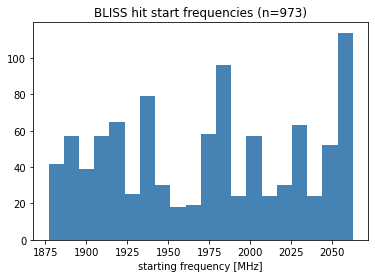

In [47]:
plt.hist(freqs, bins=20, color='steelblue')
plt.title(f'BLISS hit start frequencies (n={len(freqs)})')
plt.xlabel('starting frequency [MHz]')
#plt.grid()
plt.show()

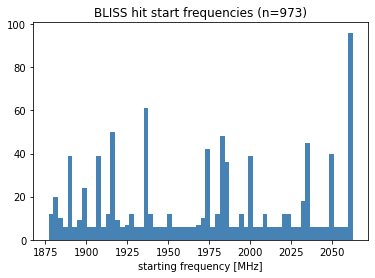

In [55]:
plt.hist(freqs, bins=64, color='steelblue')
plt.title(f'BLISS hit start frequencies (n={len(freqs)})')
plt.xlabel('starting frequency [MHz]')
#plt.yscale('log')
#plt.grid()
plt.show()

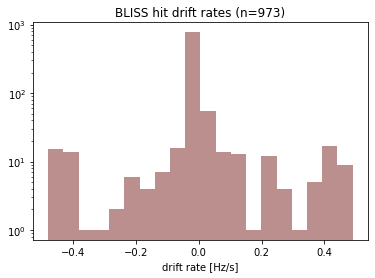

In [51]:
plt.hist(drifts, bins=20, color='rosybrown')
plt.title(f'BLISS hit drift rates (n={len(freqs)})')
plt.xlabel('drift rate [Hz/s]')
plt.yscale('log')
#plt.grid()
plt.show()

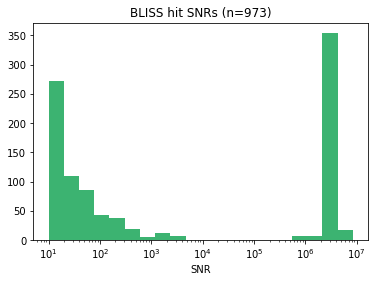

In [50]:
hist, bins = np.histogram(snrs, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.hist(snrs, bins=logbins, color='mediumseagreen')
plt.title(f'BLISS hit SNRs (n={len(freqs)})')
plt.xlabel('SNR')
plt.xscale('log')
#plt.grid()
plt.show()

In [78]:
fp_freqs = [1975.001730, 1916.669619, 2062.542771, 2034.030202]
fp_drifts = [0.020409, 0.010204, -0.010204, 0.010204]
fp_snrs = [190.907303, 252.999557, 13.241592, 132.769974]

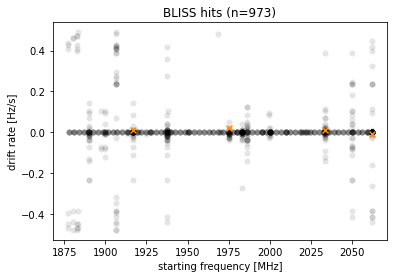

In [81]:
plt.scatter(freqs, drifts, c='k', alpha=0.1, linewidths=0)
plt.scatter(fp_freqs, fp_drifts, c='darkorange', marker='x')
plt.xlabel('starting frequency [MHz]')
plt.ylabel('drift rate [Hz/s]')
plt.title(f'BLISS hits (n={len(freqs)})')
plt.show()

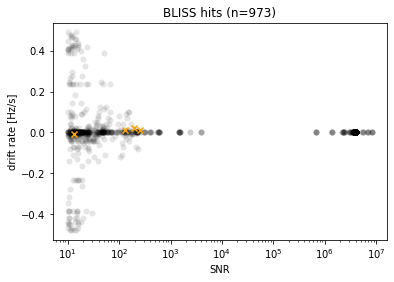

In [82]:
plt.scatter(snrs, drifts, c='k', alpha=0.1, linewidths=0)
plt.scatter(fp_snrs, fp_drifts, c='orange', marker='x')
plt.xlabel('SNR')
plt.ylabel('drift rate [Hz/s]')
plt.xscale('log')
plt.title(f'BLISS hits (n={len(freqs)})')
plt.show()

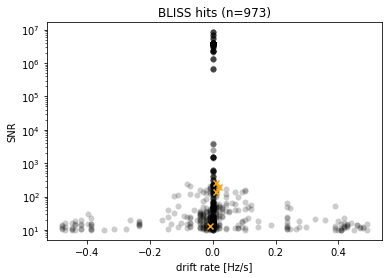

In [84]:
plt.scatter(drifts, snrs, c='k', alpha=0.2, linewidths=0)
plt.scatter(fp_drifts, fp_snrs, c='orange', marker='x')
plt.ylabel('SNR')
plt.xlabel('drift rate [Hz/s]')
plt.yscale('log')
plt.title(f'BLISS hits (n={len(freqs)})')
plt.show()

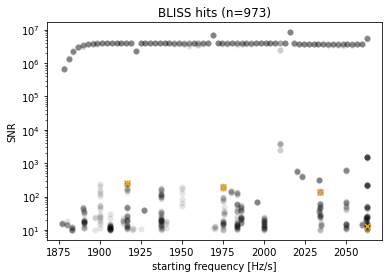

In [85]:
plt.scatter(freqs, snrs, c='k', alpha=0.1, linewidths=0)
plt.scatter(fp_freqs, fp_snrs, c='orange', marker='x')
plt.xlabel('starting frequency [Hz/s]')
plt.ylabel('SNR')
plt.yscale('log')
plt.title(f'BLISS hits (n={len(freqs)})')
plt.show()

In [2]:
dats = glob.glob('/datax/scratch/benjb/m31_l_data/*.dat')

In [7]:
print(dats[0])
with open(dats[0],"r") as f:
   file_content = f.read()
   print(file_content)

/datax/scratch/benjb/m31_l_data/blc71_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
# -------------------------- o --------------------------
# File ID: blc71_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 
# -------------------------- o --------------------------
# Source:MESSIER031
# MJD: 58832.187604166669	RA: 0h42m44.448s	DEC: 41d16m03.72s
# DELTAT:  18.253611	DELTAF(Hz):  -2.793968
# --------------------------
# Top_Hit_# 	Drift_Rate 	SNR 	Uncorrected_Frequency 	Corrected_Frequency 	Index 	freq_start 	freq_end 	SEFD 	SEFD_freq 	Coarse_Channel_Number 	Full_number_of_hits 	
# --------------------------
001	 -0.000000	1865466.748125	   2062.499999	   2062.499999	524288	   2062.501633	   2062.498370	0.0	      0.000000	0	40856	
002	 -0.000000	907108.697019	   2059.570311	   2059.570311	524288	   2059.571946	   2059.568682	0.0	      0.000000	1	13168	
003	 -0.000000	909470.840159	   2056.640624	   2056.640624	524288	   2056.642258	   2056.638995	0.0	      0.000000	2	13168	
004	 -

In [40]:
ts_freqs = []
ts_drifts = []
ts_snrs = []
for i in range(len(dats)):
    df = pd.read_table(dats[i], sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    fs = df['freq_start'].values
    ds = df['Drift_Rate'].values
    ss = df['SNR'].values
    ts_freqs = np.concatenate((ts_freqs, fs))
    ts_drifts = np.concatenate((ts_drifts, ds))
    ts_snrs = np.concatenate((ts_snrs, ss))
print(ts_freqs)
print(len(ts_freqs))

[2062.501633 2059.571946 2056.642258 2053.712571 2050.782883 2050.001634
 2049.999558 2047.853196 2044.923508 2041.993821 2039.064133 2036.134446
 2034.031809 2033.97779  2033.973541 2033.483775 2033.330241 2033.204758
 2030.275071 2027.345383 2024.415696 2022.931319 2021.486008 2020.001632
 2018.556321 2015.626633 2012.696946 2010.001633 2009.767258 2006.837571
 2003.907883 2000.978196 1998.048508 1995.537349 1995.118821 1992.189133
 1989.259446 1986.329758 1986.032254 1985.974025 1983.400071 1983.337329
 1980.470383 1980.001634 1977.540696 1975.45171  1975.003312 1974.611008
 1971.681321 1968.751633 1965.821946 1962.892258 1959.962571 1957.032883
 1954.103196 1951.173508 1950.001634 1948.243821 1945.314133 1942.384446
 1939.454758 1937.505834 1937.499707 1936.525071 1933.595383 1930.665696
 1927.736008 1924.806321 1921.876633 1918.946946 1916.671253 1916.017258
 1913.087571 1910.157883 1907.228196 1904.298508 1901.368821 1900.002601
 1898.439133 1895.509446 1892.579758 1889.979024 18

In [20]:
freqs = df['freq_start'].values
drifts = df['Drift_Rate'].values
snrs = df['Drift_Rate'].values

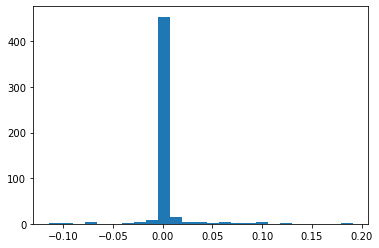

In [41]:
plt.hist(ts_drifts, bins=25)
plt.show()

In [42]:
c = bldw.Connection()
md = c.fetch_metadata_by_observation_id(47067)
for i in md:
    print(i.__str__())

file://gb-bls6/datax/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 | 2019-12-15 04:30:09 (deleted)
file://gb-bls9/datax3/pipeline/AGBT19B_999_121/blc76_blp06/blc76_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 | 2019-12-15 04:30:09 (deleted)
file://gb-bls9/datax3/pipeline/AGBT19B_999_121/blc76_blp06/blc76_guppi_58832_16209_MESSIER031_0057.gpuspec.0001.h5 | 2019-12-15 04:30:09 (deleted)
file://gb-bls9/datax3/pipeline/AGBT19B_999_121/blc76_blp06/blc76_guppi_58832_16209_MESSIER031_0057.gpuspec.0002.h5 | 2019-12-15 04:30:09 (deleted)
file://pd-datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 | 2019-12-15 04:30:09
file://pd-datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0001.h5 | 2019-12-15 04:30:09
file://pd-datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0002.h5 | 2019-12-15 04:30:09
file://gb-bls5/datax

In [ ]:
### REWRITING PARAMETER_PULLING.IPYNB SCRIPT TO READ ARRAY INTO MEMORY AT BEGINNING

# pull spectral kurtosis, skewness, Sarle's coefficient, correlation of kurtosis-log(bandwidth)

fb = bl.Waterfall(lfiles[0]) # only first ON pointing for now

caleb_wl = 0.002700    # 2.7 kHz, from Caleb Painter's work

freqs, full_dynamic_spectrum = fb.grab_data() # grab data around hit

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ctr_freqs = df['Uncorrected_Frequency'].values
start_freqs = df['freq_start'].values
end_freqs = df['freq_end'].values

drifts = df['Drift_Rate'].values
snrs = df['SNR'].values

kurts = []
skews = []
sarles = []
tbws = []
corrs = []

for ii, freq in enumerate(ctr_freqs):

    print(f'Beginning analysis of hit at frequency {freq} MHz ...')

    dynamic_spectrum = full_dynamic_spectrum[np.where((freqs < freq+caleb_wl/2) & (freqs > freq-caleb_wl/2))[0]]
    print(np.shape(dynamic_spectrum)) # check to make sure we've sliced along the correct axis

    freqs, dynamic_spectrum = fb.grab_data(f_start=freq-caleb_wl/2, f_stop=freq+caleb_wl/2) # grab data around hit
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide

    ku = kurtosis(power_spectrum, fisher=False)  # Pearson (not Fisher) for Sarle calculation
    sk = skew(power_spectrum)
    sarle = (sk**2 + 1) / ku           # Sarle's bimodality coefficient
                                       # = 5/9 for uniform, larger possibly suggests multimodality

    print(f'Hit number {ii} of {len(ctr_freqs)}:')
    print(f'    Spectral kurtosis is {ku}.')
    print(f'    Spectral skewness is {sk}.')
    print(f'    Sarle\'s coefficient is {sarle}.')

    kurts.append(ku)
    skews.append(sk)
    sarles.append(sarle)

    window_lengths = np.logspace(np.log10(0.0002), np.log10(0.0500), 50)
    mini_kurts = []

    for wl in window_lengths:
        freqs, dynamic_spectrum = fb.grab_data(f_start=freq-wl/2, f_stop=freq+wl/2) # grab data around hit
        power_spectrum = np.average(dynamic_spectrum, axis=0)
        power_spectrum = power_spectrum / power_spectrum.max()
        mk = kurtosis(power_spectrum, fisher=False)
        print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
        mini_kurts.append(mk)

    turning_bandwidth = window_lengths[np.argmax(mini_kurts)]
    tbws.append(turning_bandwidth)

    subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
    subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]

    correlation_coefficient = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]
    corrs.append(correlation_coefficient)

    print(f'    Maximum kurtosis occurs at bandwidth {turning_bandwidth}.')
    print(f'    Correlation coefficient is {correlation_coefficient}.')

    #plt.scatter(np.array(window_lengths)*1000000, mini_kurts)
    #plt.xlabel('window bandwidth [Hz]')
    #plt.ylabel('Pearson kurtosis')
    #plt.xscale('log')
    #plt.show()

    #break

kurts = np.array(kurts)
skews = np.array(skews)
sarles = np.array(sarles)
tbws = np.array(tbws)
corrs = np.array(corrs)

#np.savez('/datax/scratch/benjb/kurtoses.npz', kurts)
#np.savez('/datax/scratch/benjb/skewnesses.npz', skews)
#np.savez('/datax/scratch/benjb/sarles.npz', sarles)
np.savez('/datax/scratch/benjb/tbws.npz', tbws)  # turning bandwidths [MHz]
np.savez('/datax/scratch/benjb/corrs.npz', corrs) # Pearson correlation coefficients

print('Done!')